UTILS FUNCTIONS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
def plot_histo(df: pd.DataFrame | pd.Series, title: str, ylabel: str, xlabel: str = 'Date'):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)
    plt.figure(figsize=(14, 6))
    plt.plot(df, label=df.columns)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_heatmap(df: pd.DataFrame, title: str, ylabel: str, xlabel: str):
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=df.columns,  # shock from
        yticklabels=df.columns,  # affected variable
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

DATA FETCHING & CLEANING

In [ ]:
import yfinance as yf

In [ ]:
# Download params
START_DATE = "2006-01-01"
END_DATE = "2018-12-31"
TICKERS = [
    "ZT=F",
    "ZS=F",
    "ZR=F",
    "ZO=F",
    "ZN=F",
    "ZM=F",
    "ZL=F",
    "ZF=F",
    "ZC=F",
    "ZB=F",
    "YM=F",
    "SIL=F",
    # "SI=F", # No data available in 2006
    "SB=F",
    # "RTY=F", # No data available in 2006
    "RB=F",
    "PL=F",
    # "PA=F", # No data available in 2006
    "OJ=F",
    "NQ=F",
    "NG=F",
    # "MGC=F", # No data available in 2006
    # "LE=F", # No data available in 2006
    "LBS=F",
    "KE=F",
    "KC=F",
    "HO=F",
    "HG=F",
    "HE=F",
    "GF=F",
    "GC=F",
    "ES=F",
    "CT=F",
    "CL=F",
    "CC=F",
    # "BZ=F", # No data available in 2006
    # "B0=F", # not found
] # List of all commodities availables on YahooFinance the 04/06/2025

In [3]:
# Download financial data
df = yf.download(TICKERS, start=START_DATE, end=END_DATE, group_by="tickers", auto_adjust=True)

[*********************100%***********************]  31 of 31 completed


In [ ]:
# Data cleaning
MISSING_THRESHOLD = 0.05

inconsistent_tickers = [
    ticker
    for ticker in df.columns.levels[0]
    if ("Close" in df[ticker].columns and df[(ticker, "Close")].isna().mean() > MISSING_THRESHOLD)
]
print(f"Dropping tickers: {inconsistent_tickers} due to missing value above threshold of {MISSING_THRESHOLD:.0%}")
data = df.drop(columns=inconsistent_tickers, level=0)  # dropping tickers
data = data.bfill()  # backfilling

close = data.xs("Close", axis=1, level=1)

print(f"Tickers: {list(close.columns.levels[0])}")

Dropping tickers: ['PL=F', 'SIL=F'] due to missing value above threshold of 5%
Tickers: ['CC=F', 'CL=F', 'CT=F', 'ES=F', 'GC=F', 'GF=F', 'HE=F', 'HG=F', 'HO=F', 'KC=F', 'KE=F', 'LBS=F', 'NG=F', 'NQ=F', 'OJ=F', 'PL=F', 'RB=F', 'SB=F', 'SIL=F', 'YM=F', 'ZB=F', 'ZC=F', 'ZF=F', 'ZL=F', 'ZM=F', 'ZN=F', 'ZO=F', 'ZR=F', 'ZS=F', 'ZT=F', '^GSPC']


DYIC

In [ ]:
import warnings
from statsmodels.tsa.api import VAR
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.vector_ar.var_model import VARResultsWrapper

In [ ]:
def roll(df: pd.DataFrame, window_size: int):
    """
    Generates rolling windows of a DataFrame.
    Yields:
    -------
    pd.DataFrame
        A rolling window of the DataFrame.
    """
    for i in range(len(df) - window_size):
        yield df.iloc[i : i + window_size]

def generalized_fevd(var_results: "VARResultsWrapper", horizon: int):
    """
    Compute the Generalized Forecast Error Variance Decomposition (GFEVD)
    for a fitted VAR model, as described by Diebold and Yilmaz. Implementation made by chatpgt and gemini

    Returns:
    --------
    gfevd_matrix: np.ndarray
        N x N matrix where element (i,j) is the contribution of shock j
        to the forecast error variance of variable i.
    """
    sigma_u = var_results.sigma_u  # Residual covariance matrix, shape (N, N)
    if isinstance(sigma_u, pd.DataFrame):
        sigma_u = sigma_u.values

    var_coeffs = var_results.coefs  # VAR coefficient matrices, shape (lag, N, N)
    p_lags, N, _ = var_coeffs.shape

    # Compute MA coefficient matrices A_h for h=0,...,H-1
    ma_coeffs = np.zeros((horizon, N, N))
    ma_coeffs[0] = np.eye(N)
    for h in range(1, horizon):
        for k in range(1, p_lags + 1):
            if h - k >= 0:
                ma_coeffs[h] += np.dot(var_coeffs[k - 1], ma_coeffs[h - k])

    # Calculate GFEVD (theta_ij elements before normalization)
    gfevd_unnormalized = np.zeros((N, N))

    # Calculate denominators
    denominators = np.zeros(N)
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        for h in range(horizon):  # Sum from h=0 to H-1
            term = np.dot(ma_coeffs[h], np.dot(sigma_u, ma_coeffs[h].T))
            denominators[i] += np.dot(e_i.T, np.dot(term, e_i))

    # Calculate each element (i,j) of the GFEVD matrix
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        for j in range(N):
            e_j = np.zeros(N)
            e_j[j] = 1.0

            sigma_jj_inv = 1.0 / sigma_u[j, j]
            if np.isinf(sigma_jj_inv) or np.isnan(sigma_jj_inv):  # Handle potential division by zero if sigma_jj is 0
                print(
                    f"Warning: sigma_jj for variable {j} is zero or very small. Setting sigma_jj_inv to a large number."
                )
                sigma_jj_inv = 1e12  # A large number to avoid NaN, but indicates an issue

            numerator_sum_sq = 0.0
            for h in range(horizon):
                val = np.dot(e_i.T, np.dot(ma_coeffs[h], np.dot(sigma_u, e_j)))
                numerator_sum_sq += val**2

            if denominators[i] == 0:
                # This implies the forecast error variance of variable i is zero, problematic.
                print(f"Warning: Denominator for GFEVD for variable {i} is zero. Setting GFEVD contribution to 0.")
                gfevd_unnormalized[i, j] = 0.0
            else:
                gfevd_unnormalized[i, j] = (sigma_jj_inv * numerator_sum_sq) / denominators[i]

    # Normalize rows to sum to 1 to get the Pairwise Connectedness Matrix C^H_{i <- j}
    row_sums = gfevd_unnormalized.sum(axis=1, keepdims=True)
    # Handle cases where a row sum is zero (e.g., if a variable has zero forecast error variance)
    safe_row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace 0 with 1 to avoid NaN, result will be 0.
    gfevd_normalized = gfevd_unnormalized / safe_row_sums
    gfevd_normalized = np.where(row_sums == 0, 0, gfevd_normalized)  # Ensure original zero rows are zero

    return gfevd_normalized

def get_dyci(
    returns: pd.DataFrame, rolling_window: int, forecast_horizon: int, max_lag: int
) -> tuple[pd.Series, np.ndarray]:
    tci = []  # Total Connectedness Index values
    gfevd_matrices = []  # GFEVD matrices for each window

    # Iterate through rolling windows
    counter = 0
    for window_data in roll(returns, rolling_window):
        model = VAR(window_data)
        results = model.fit(maxlags=max_lag)

        # Calculate Generalized Forecast Error Variance Decomposition (GFEVD)
        gfevd_matrix = generalized_fevd(results, forecast_horizon)
        gfevd_matrices.append(gfevd_matrix)

        # Calculate Total Connectedness Index (TCI)
        total_connectedness = 100 * (1 - np.trace(gfevd_matrix) / len(returns.columns))
        tci.append(total_connectedness)
        if counter % 200 == 0:
            print(f"Lag {counter} completed in DYCI ({counter / len(returns):.2%})")
        counter += 1

    # Create a pandas Series for the TCI for easier plotting
    tci_series = pd.Series(tci, index=returns.index[rolling_window : rolling_window + len(tci)], name='TCI')
    return tci_series, np.array(gfevd_matrices)

In [ ]:
## Parameters for DYIC as per https://financialconnectedness.org/info_stock.html
ROLLING_WINDOW = 150
FORECAST_HORIZON = 10
MAX_LAG = 3

# Remove model VAR Warning -> ValueWarning: No frequency information was provided, so inferred frequency B will be used.
warnings.filterwarnings("ignore", category=ValueWarning)

returns = np.log(close / close.shift()).dropna()
tci_series, gfevd_matrices = get_dyci(returns, ROLLING_WINDOW, FORECAST_HORIZON, MAX_LAG)


Lag 0 completed in DYCI (0.00%)
Lag 200 completed in DYCI (6.10%)
Lag 400 completed in DYCI (12.20%)
Lag 600 completed in DYCI (18.30%)
Lag 800 completed in DYCI (24.41%)
Lag 1000 completed in DYCI (30.51%)
Lag 1200 completed in DYCI (36.61%)
Lag 1400 completed in DYCI (42.71%)
Lag 1600 completed in DYCI (48.81%)
Lag 1800 completed in DYCI (54.91%)
Lag 2000 completed in DYCI (61.01%)
Lag 2200 completed in DYCI (67.11%)
Lag 2400 completed in DYCI (73.22%)
Lag 2600 completed in DYCI (79.32%)
Lag 2800 completed in DYCI (85.42%)
Lag 3000 completed in DYCI (91.52%)


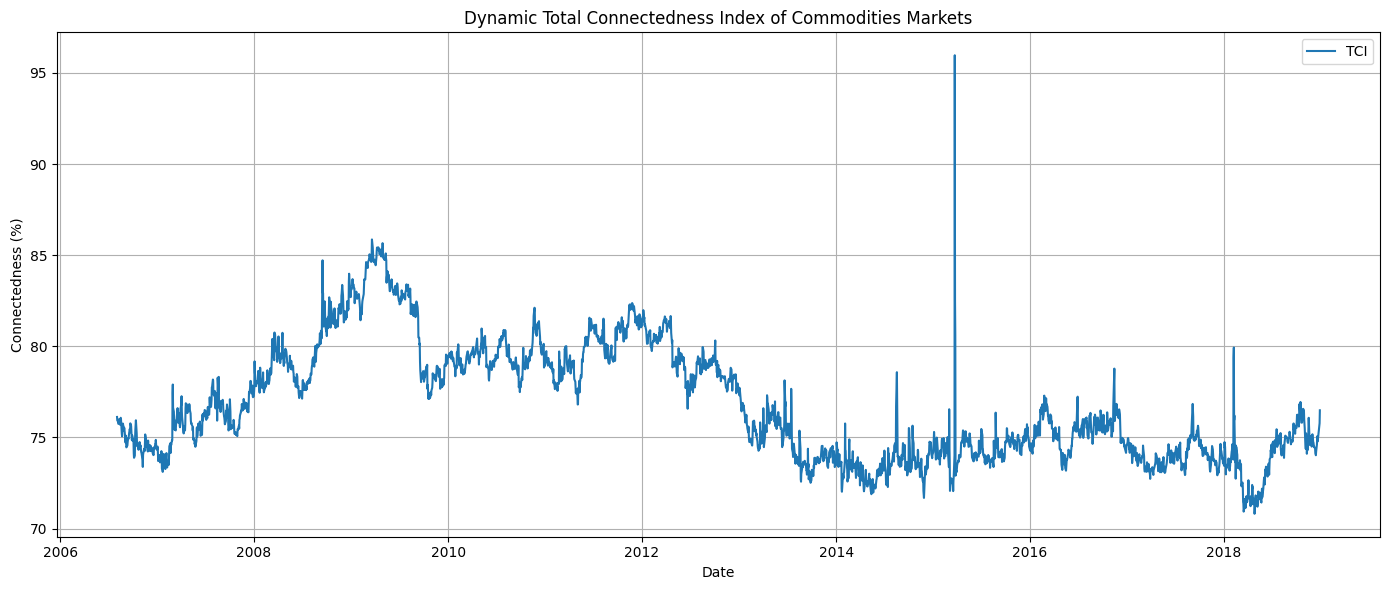

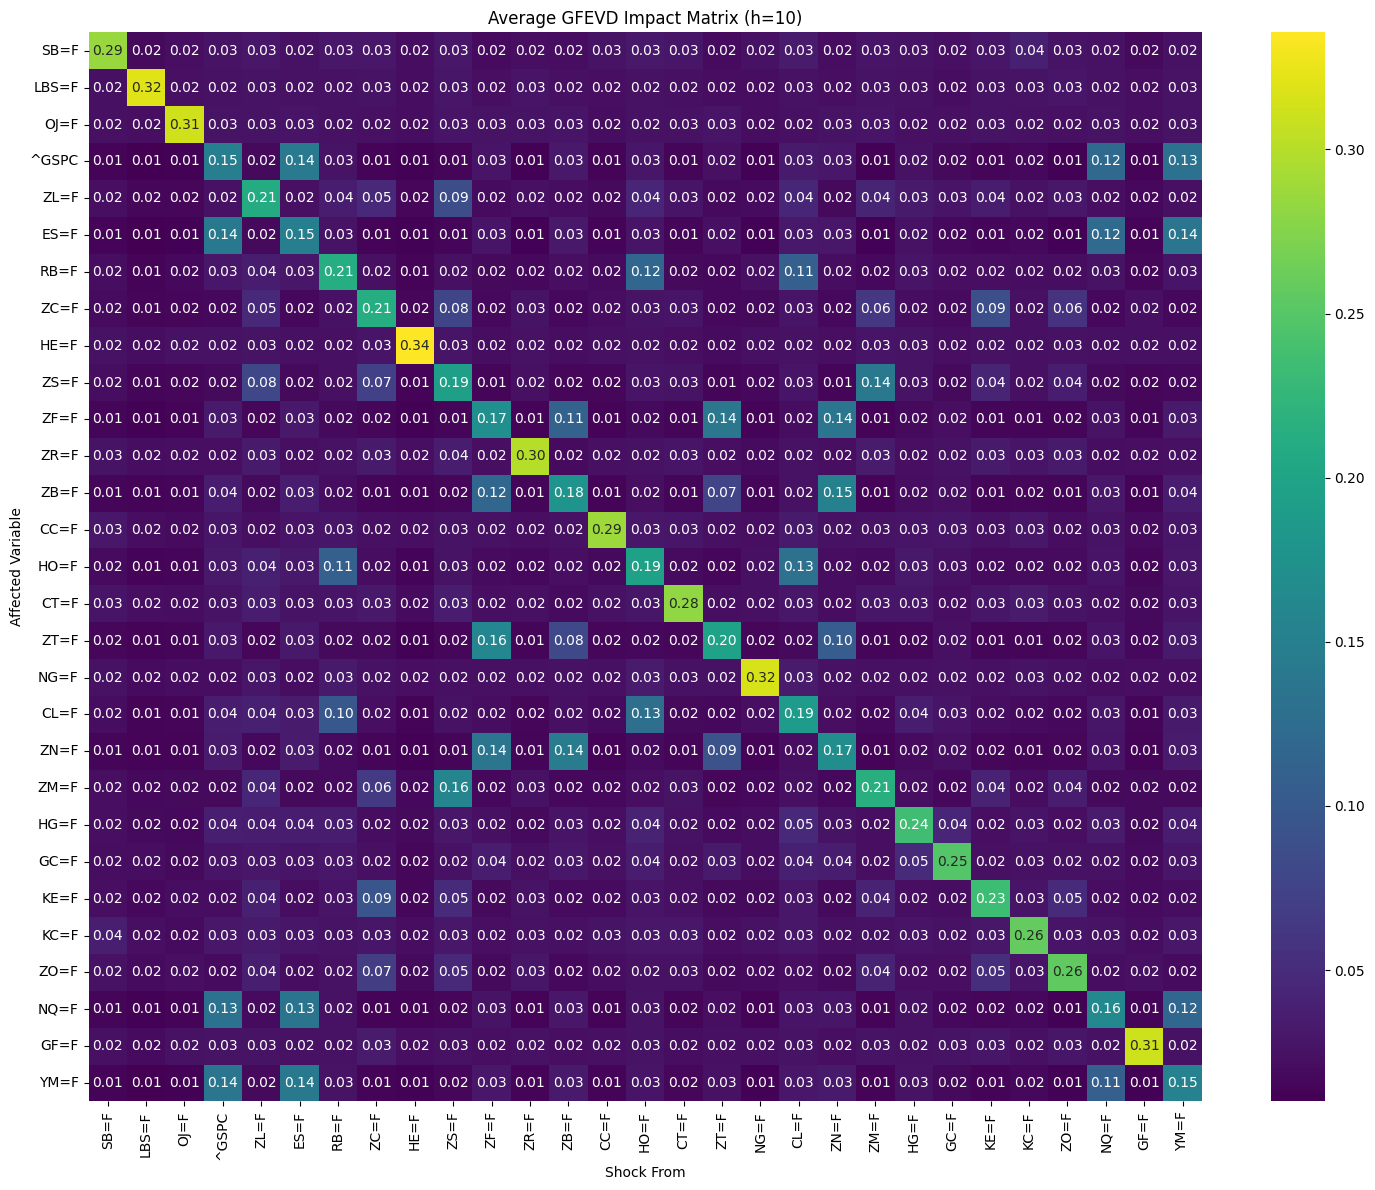

In [43]:
avg_gfevd = pd.DataFrame(np.mean(gfevd_matrices, axis=0), index=close.columns, columns=close.columns)

plot_histo(tci_series, title='Dynamic Total Connectedness Index of Commodities Markets', ylabel='Connectedness (%)')
plot_heatmap(avg_gfevd, title=f"Average GFEVD Impact Matrix (h={FORECAST_HORIZON})", ylabel="Affected Variable", xlabel="Shock From")

PORTFOLIO OPTIMIZATION USING DYIC

In [30]:
from pypfopt import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pprint import pprint

In [ ]:
mu = mean_historical_return(close)

ef = EfficientFrontier(mu, avg_gfevd)
w = ef.max_sharpe()

pprint({ticker: w for ticker, w in w.items() if w > 0})

{'CC=F': 0.0320742424589171,
 'GC=F': 0.2026898938256699,
 'GF=F': 0.0132688450256164,
 'NQ=F': 0.5865174800302866,
 'ZC=F': 0.1097035319330762,
 'ZM=F': 0.0557460067264339}


PORTFOLIO OPTIMIZATION USING COVARIANCE MATRIX

In [25]:
from pypfopt.risk_models import risk_matrix

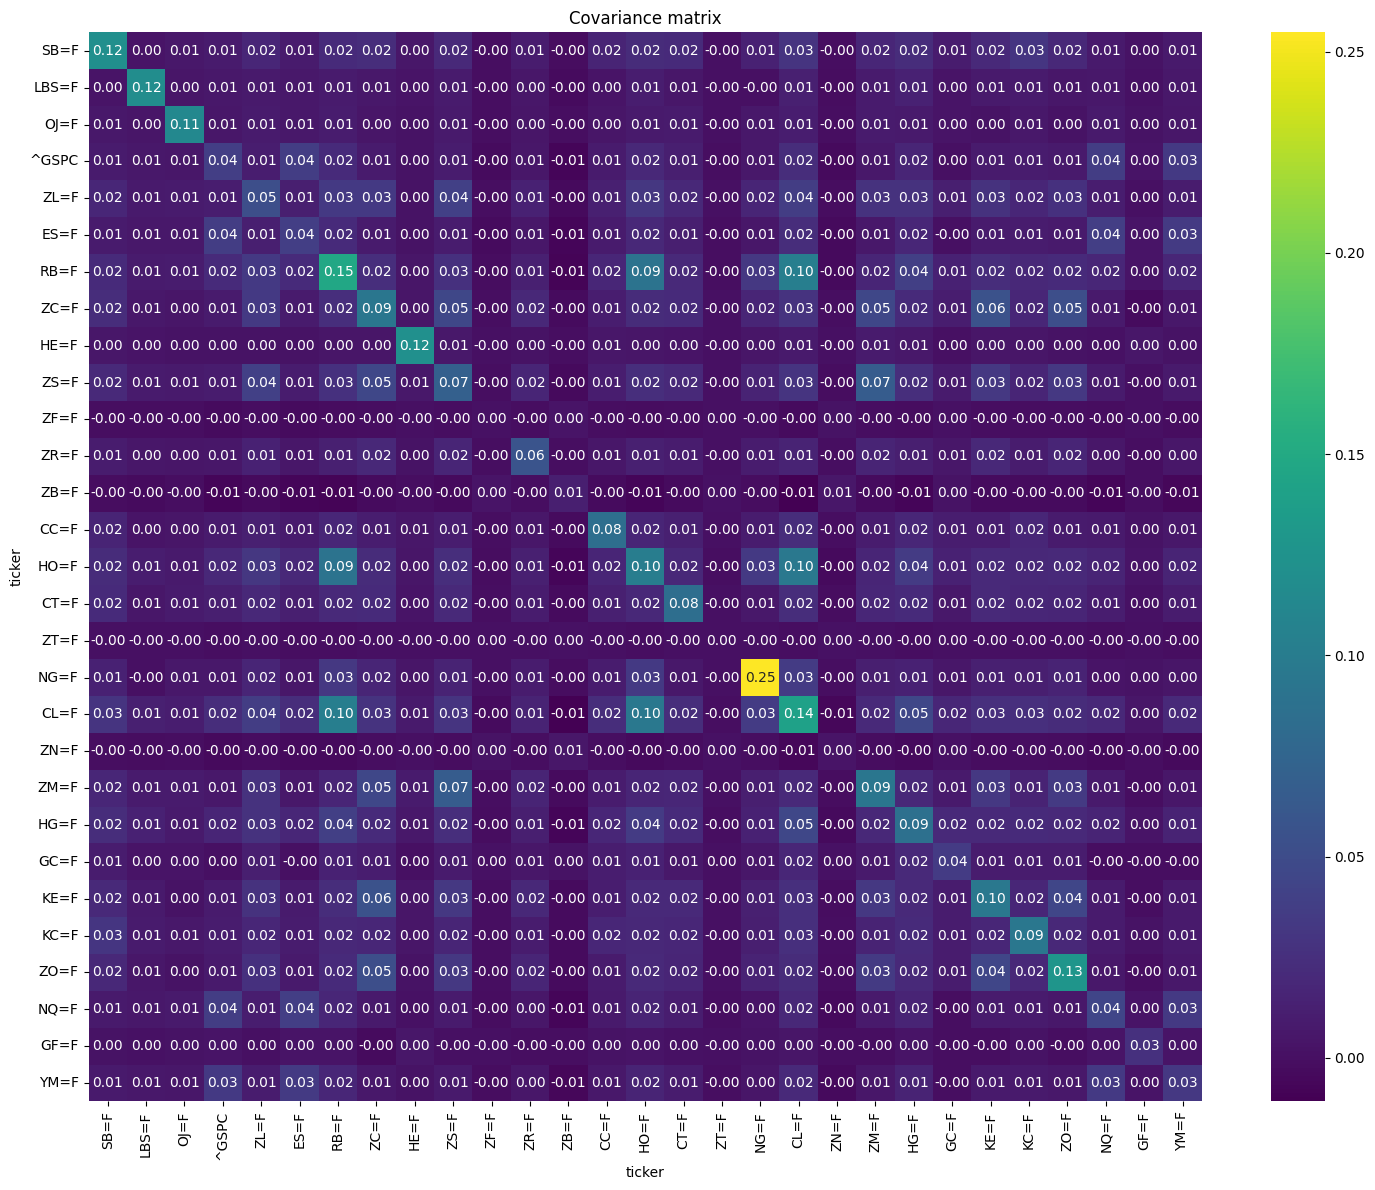

In [44]:
cov_matrix = risk_matrix(close)
plot_heatmap(cov_matrix, title='Covariance matrix', ylabel='ticker', xlabel='ticker')

In [46]:
ef = EfficientFrontier(mu, cov_matrix)
w = ef.max_sharpe()

pprint({ticker: w for ticker, w in w.items() if w > 0.001}) # Removing e-16 values  

{'GC=F': 0.0746230568976267,
 'GF=F': 0.0272491555495248,
 'NQ=F': 0.130287519870681,
 'ZB=F': 0.0930791793043002,
 'ZC=F': 0.0046723335740897,
 'ZM=F': 0.0036896264464822,
 'ZT=F': 0.6663991283572935}
